# Object Detection on Braid Defect Images

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import gc
import PIL
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *

In [3]:
os.chdir('..')
from helper.object_detection_helper import *
from loss.RetinaNetFocalLoss import RetinaNetFocalLoss
from models.RetinaNet import RetinaNet
from callbacks.callbacks import BBLossMetrics, BBMetrics, PascalVOCMetric

## Dataset

In [4]:
!ls ../defect_detection/

 Image00010.BMP			      'Image08-19-2019 - 14.36.23.025.BMP'
 Image00020.BMP			      'Image08-19-2019 - 14.40.22.495.BMP'
 Image00030.BMP			      'Image08-19-2019 - 14.41.24.972.BMP'
 Image00060.BMP			       images-underpack-complete
'Image08-19-2019 - 14.24.13.827.BMP'   preprocess.ipynb


In [5]:
path = Path('../defect_detection/images-underpack-complete')
# path = untar_data(URLs.COCO_SAMPLE)
path.ls()

[PosixPath('../defect_detection/images-underpack-complete/weights'),
 PosixPath('../defect_detection/images-underpack-complete/models'),
 PosixPath('../defect_detection/images-underpack-complete/labels'),
 PosixPath('../defect_detection/images-underpack-complete/images')]

In [6]:
images, lbl_bbox = get_annotations(path/'labels/defect_labels_coco_120px.json')
# images, lbl_bbox = get_annotations(path/'annotations/train_sample.json')
img2bbox = dict(zip(images, lbl_bbox))
get_y_func = lambda o:img2bbox[o.name]

In [7]:
len(images)

410

In [8]:
img2bbox['Image00003.BMP']

[[[216, 0, 336, 120],
  [450, 0, 570, 120],
  [210, 1468, 330, 1588],
  [194, 1980, 314, 2100],
  [686, 1504, 806, 1624],
  [646, 2872, 766, 2992],
  [386, 944, 506, 1064],
  [196, 3242, 316, 3362],
  [204, 3404, 324, 3524],
  [206, 3920, 326, 4040],
  [430, 3732, 550, 3852],
  [416, 3402, 536, 3522],
  [400, 2938, 520, 3058]],
 ['defect',
  'defect',
  'defect',
  'defect',
  'defect',
  'defect',
  'defect',
  'defect',
  'defect',
  'defect',
  'defect',
  'defect',
  'defect']]

In [7]:
img1 = open_image(path/'images/Image00003.BMP')
img1.size

torch.Size([1100, 4096])

In [8]:
img2 = open_image(path/'images/Image08-07-2019 - 11.07.30.992.BMP')
img2.size

torch.Size([550, 2048])

## Resize Image

In [16]:
final_size = 1024

In [48]:
im = PIL.Image.open(path/'images/Image08-07-2019 - 11.07.30.992.BMP')
old_size = im.size
old_size

(2048, 550)

In [50]:
ratio = float(final_size) / max(old_size)
new_size = tuple([int(x * ratio) for x in old_size])

In [51]:
im = im.resize(new_size, PIL.Image.ANTIALIAS)
new_im = PIL.Image.new("RGB", (final_size, final_size))
new_im.paste(im, ((final_size - new_size[0]) // 2, (final_size - new_size[1]) // 2))
new_im.show()

In [ ]:
def open_image_square(fn:PathOrStr, div:bool=True, convert_mode:str='RGB', cls:type=Image,
        after_open:Callable=None)->Image:
    "Return `Image` object created from image in file `fn`."
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning) # EXIF warning from TiffPlugin
        x = PIL.Image.open(fn).convert(convert_mode)
    if after_open: x = after_open(x)
    x = pil2tensor(x,np.float32)
    if div: x.div_(255)
    return cls(x)

## Generate Databunch

In [9]:
size = (512, 2048) #np.array(img2.size)
print(f"size: {size}")

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=4
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

size: (512, 2048)
using bs=1, have 0MB of GPU RAM free


In [10]:
data = (ObjectItemList.from_folder(path)
        .split_by_rand_pct()
        .label_from_func(get_y_func)
        .transform(get_transforms(do_flip=False, max_rotate=None, max_zoom=1, max_lighting=0.2, max_warp=None, p_affine=0.75, p_lighting=0.75), tfm_y=True, size=size, resize_method=ResizeMethod.PAD, padding_mode='zeros')
        .databunch(bs=bs, collate_fn=bb_pad_collate))

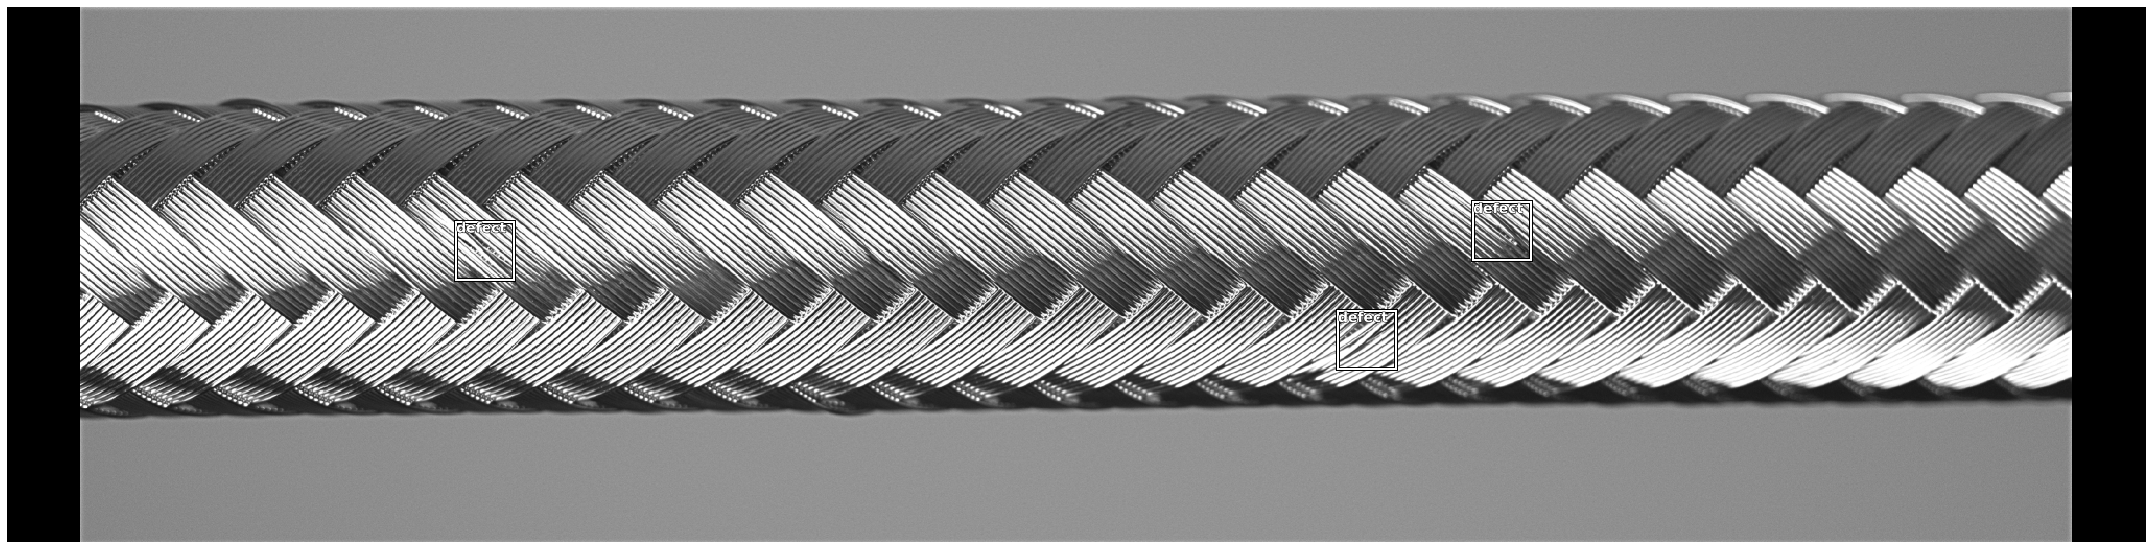

In [11]:
data.show_batch(rows=5, ds_type=DatasetType.Valid, figsize=(30, 10))

In [20]:
data.classes

['background', 'defect']

In [21]:
data.train_ds.c

2

## Model

In [11]:
size[0] / size[1]

0.25

In [11]:
# anchors = create_anchors(sizes=[(32,32),(16,16),(8,8)], ratios=[0.5, 1, 1.5], scales=[0.35, 0.5, 0.6, 1, 1.25, 1.6])
anchors = create_anchors(sizes=[(512,512),(256,256),(128,128),(64,64),(32,32)], ratios=[2, 4, 6], scales=[1, 1.26, 1.59])
len(anchors)

3142656

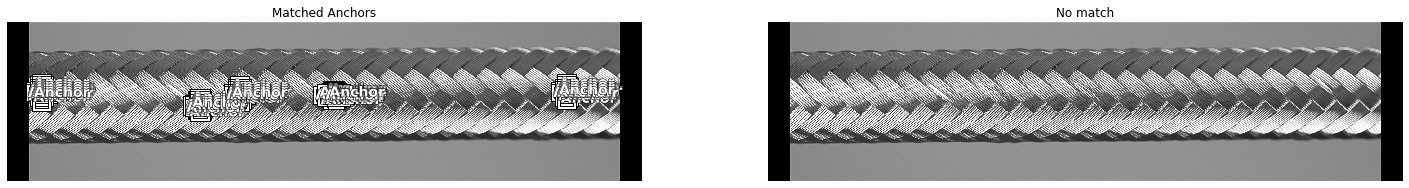

In [12]:
all_boxes, all_labels = show_anchors_on_images(data, anchors, figsize=(25,25))

In [57]:
def _get_sfs_idxs(sizes:Sizes) -> List[int]:
    "Get the indices of the layers where the size of the activation changes."
    feature_szs = [size[-1] for size in sizes]
    sfs_idxs = list(np.where(np.array(feature_szs[:-1]) != np.array(feature_szs[1:]))[0])
    if feature_szs[0] != feature_szs[1]: sfs_idxs = [0] + sfs_idxs

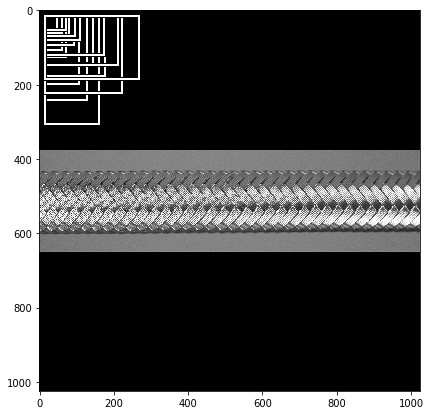

In [24]:
fig, ax = plt.subplots(figsize=(20,7))
ax.imshow(image2np(data.valid_ds[0][0].data))

for i, bbox in enumerate(anchors[:18]):
    bb = bbox.numpy()
    x = (bb[0] + 1) * size[1] / 2
    y = (bb[1] + 1) * size[0] / 2
    w = bb[2] * size[1] / 2
    h = bb[3] * size[0] / 2
    # x = (bb[0] + 1) * size / 2
    # y = (bb[1] + 1) * size / 2
    # w = bb[2] * size / 2
    # h = bb[3] * size / 2

    rect = [x, y, w, h]
    draw_rect(ax, rect)

In [48]:
del voc
del crit
del learn
del model
del encoder
gc.collect()

3743

In [13]:
n_classes = data.train_ds.c

crit = RetinaNetFocalLoss(anchors)

encoder = create_body(models.resnet34, True, -2)
model = RetinaNet(encoder, n_classes=n_classes, n_anchors=18, sizes=[32,16,8], chs=32, final_bias=-4., n_conv=2)

In [14]:
model_sizes(encoder, size)

[torch.Size([1, 64, 256, 1024]),
 torch.Size([1, 64, 256, 1024]),
 torch.Size([1, 64, 256, 1024]),
 torch.Size([1, 64, 128, 512]),
 torch.Size([1, 64, 128, 512]),
 torch.Size([1, 128, 64, 256]),
 torch.Size([1, 256, 32, 128]),
 torch.Size([1, 512, 16, 64])]

In [44]:
with hook_outputs(encoder) as hooks:
    dummy_eval(encoder, size).size()
    for h in hooks:
        print(h.stored.size())

torch.Size([1, 64, 275, 1024])
torch.Size([1, 64, 275, 1024])
torch.Size([1, 64, 275, 1024])
torch.Size([1, 64, 138, 512])
torch.Size([1, 64, 138, 512])
torch.Size([1, 128, 69, 256])
torch.Size([1, 256, 35, 128])
torch.Size([1, 512, 18, 64])


In [14]:
voc = PascalVOCMetric(anchors, size, [i for i in data.train_ds.y.classes[1:]])
learn = Learner(data, model, loss_func=crit, callback_fns=[ShowGraph, BBMetrics], metrics=[voc])

the retinanet models return three objects:

1. [1, 24480, 3] -> [Batchsize, number of boxes, classes + background] -> 
classification results for each anchor
2. [1, 24480, 4] -> [Batchsize, number of boxes, box-coordinates refinements] -> how the anchors should be resized to match the objects in the image
3. Feature map shapes. You can ignore that for a start is more for debug purposes

In [15]:
learn.split([model.encoder[6], model.c5top5])
learn.freeze_to(-2)

In [17]:
learn.lr_find()
learn.recorder.plot()

bbox_pred: torch.Size([5760, 4]), bbox_mask: torch.Size([3142656])
bbox_pred_resize: torch.Size([3142656, 4])
clas_pred: torch.Size([5760, 2]), clas_pred_resize: torch.Size([3142656, 2])
clas_pred: torch.Size([3142588, 2])
bbox_pred: torch.Size([5760, 4]), bbox_mask: torch.Size([3142656])
bbox_pred_resize: torch.Size([3142656, 4])
clas_pred: torch.Size([5760, 2]), clas_pred_resize: torch.Size([3142656, 2])
clas_pred: torch.Size([3142592, 2])


Traceback (most recent call last):
  File "/home/dillon/anaconda3/envs/py36/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/dillon/anaconda3/envs/py36/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/dillon/anaconda3/envs/py36/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/dillon/anaconda3/envs/py36/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/dillon/anaconda3/envs/py36/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/dillon/anaconda3/envs/py36/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/dil

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


KeyboardInterrupt: 

In [17]:
lr = 2e-5

epoch,train_loss,valid_loss,pascal_voc_metric,BBloss,focal_loss,AP-defect,time
0,2.285758,2.320667,0,0.454083,1.866585,0,10:15


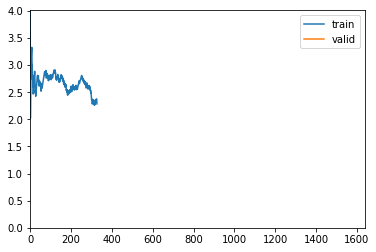

RuntimeError: The expanded size of the tensor (1) must match the existing size (2) at non-singleton dimension 0.  Target sizes: [1, 2].  Tensor sizes: [2, 2]

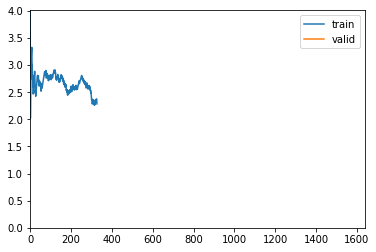

In [18]:
learn.fit_one_cycle(5, slice(lr), pct_start=0.9)

In [ ]:
im = open_image(path/'images/Image08-07-2019 - 11.07.30.992.BMP')
learn.predict(im)

In [117]:
start = time.time()
thing = learn.pred_batch(learn.data.one_item(im))
print(f"time elapsed: {time.time() - start:.2f}s")

append: torch.Size([1, 32, 32, 32])
append: torch.Size([1, 32, 16, 16])
append: torch.Size([1, 32, 8, 8])
merge: torch.Size([1, 32, 128, 128])
merge: torch.Size([1, 32, 64, 64])
merge: torch.Size([1, 32, 32, 32])
merge: torch.Size([1, 32, 16, 16])
merge: torch.Size([1, 32, 8, 8])
smooth: torch.Size([1, 32, 128, 128])
smooth: torch.Size([1, 32, 64, 64])
smooth: torch.Size([1, 32, 32, 32])
smooth: torch.Size([1, 32, 16, 16])
smooth: torch.Size([1, 32, 8, 8])
sizes: torch.Size([1, 32, 32, 32])
sizes: torch.Size([1, 32, 16, 16])
sizes: torch.Size([1, 32, 8, 8])
time elapsed: 1.11s
